In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
from sklearn.linear_model import Ridge, LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

## Big data sets: `SGDClassifier` and `SGDRegressor` (15 min)

- Something we haven't discussed in this course is huge data sets.
- There could be a couple problems arising from huge data sets:

1. The code is too slow.
2. The dataset doesn't fit in memory - I can't even load it with `pd.read_csv`. 

Simplest strategy: subset your data for experimentation / hyperparameter tuning, then train your final model on the whole dataset (once).

- "SGD" (stochastic gradient descent) can help with both of these problems.
- But we'll focus on using it to solve problem (1).
- There is a fancy way to implement `fit` that can be a lot faster for big data sets.
  - You can think of it as quickly finding "approximately" the best coefficients when calling `fit`.
  - That is not quite true but it may be a useful way of thinking.
  - Much more on this in CPSC 340 and much, much more on this in CPSC 440/540.

- SGD can be used in many contexts.
- In sklearn, it's built in as follows:

In [4]:
from sklearn.linear_model import SGDClassifier, SGDRegressor

- `SGDRegressor` is basically equivalent to `Ridge`.
- `SGDRegressor(loss='huber')` is basically equivalent to `HuberRegressor`.
- `SGDClassifier(loss='log')` is basically equivalent to `LogisticRegression`, except the parameter is called `alpha` instead of `C` (like `Ridge`).
- With other settings they are equivalent to other models, but this is good enough.

- For regular sized datasets, use the original functions, as these ones can be a bit more finicky. 

Let's load the [Sentiment140 dataset](http://help.sentiment140.com/home), which contains tweets labeled with sentiment associated with a brand, product, or topic. (I don't think we've looked at this dataset before - using it here because it's large.) You can download the data from [here](https://www.kaggle.com/ferno2/training1600000processednoemoticoncsv).

In [5]:
tweets_df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', 
                        encoding = "ISO-8859-1",
                        names=["label","id", "date", "no_query", "name", "text"])
tweets_df['label'] = tweets_df['label'].map({0: 'neg', 4: 'pos'})
tweets_df = tweets_df[tweets_df['label'].str.startswith(('pos','neg'))]

In [6]:
tweets_df_train, tweets_df_test = train_test_split(tweets_df)

In [7]:
tweets_df_train.head()

,label,id,date,no_query,name,text
843953,pos,1563972514,Mon Apr 20 01:07:37 PDT 2009,NO_QUERY,JuanMoon,@JessLoebig this city is ridiculous lol... jk....
1134521,pos,1976350370,Sat May 30 17:08:07 PDT 2009,NO_QUERY,MJJNews,"@Lex_DH Marvin Gaye, Stevie Wonder, anything ..."
303843,neg,1999580980,Mon Jun 01 20:28:06 PDT 2009,NO_QUERY,leeandradex3,"@tommcfly of you in my computer, LOL please an..."
337900,neg,2014312351,Wed Jun 03 01:06:53 PDT 2009,NO_QUERY,MizpahMijares,"my right eye hurts with my contact lense,so i ..."
215700,neg,1975543678,Sat May 30 15:22:56 PDT 2009,NO_QUERY,KtShortcake,"how do I load a profile pic, it keeps telling ..."


In [8]:
tweets_df_train.shape

(1200000, 6)

Holy cow!

In [9]:
vec = CountVectorizer(stop_words='english')

X_train = vec.fit_transform(tweets_df_train['text']) 
y_train = tweets_df_train['label']

X_test = vec.transform(tweets_df_test['text']) 
y_test = tweets_df_test['label']

In [10]:
X_train.shape

(1200000, 563780)

In [11]:
type(X_train)

scipy.sparse.csr.csr_matrix

Here is the fraction of elements that are nonzero. Having a sparse matrix really helps!!

In [12]:
X_train.nnz/np.prod(X_train.shape)

1.2347450837797249e-05

Now let's train a classifier. I'll use `time` instead of `%timeit` because I want to keep the output, and it gets lost with `%timeit`.

In [13]:
dc = DummyClassifier()
dc.fit(X_train, y_train)
dc.score(X_train, y_train)

/opt/miniconda3/envs/cpsc330env/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


0.5002458333333333

In [14]:
lr = LogisticRegression()

In [15]:
%time lr.fit(X_train, y_train);

CPU times: user 2min 35s, sys: 5.26 s, total: 2min 40s
Wall time: 24.5 s


/opt/miniconda3/envs/cpsc330env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [16]:
lr.score(X_train, y_train)

0.81016

In [17]:
lr.score(X_test, y_test)

0.7765725

In [18]:
lr.n_iter_

array([100], dtype=int32)

In [19]:
lr_sgd = SGDClassifier(loss="log")

In [20]:
%time lr_sgd.fit(X_train, y_train);

CPU times: user 5.03 s, sys: 85.6 ms, total: 5.11 s
Wall time: 3.83 s


SGDClassifier(loss='log')

In [21]:
lr_sgd.n_iter_

7

In [22]:
lr_sgd.score(X_train, y_train)

0.769875

In [23]:
lr_sgd.score(X_test, y_test)

0.76577

# TODO

think about the `C` and `alpha` hyperparameters

- `SGDClassifier` was about 10x faster than `LogisticRegression`, but the accuracy is slightly lower.
- In fact, we can control the speed vs. _train_ accuracy tradeoff in both cases using the hyperparameters.
  - The main ones are `max_iter` (higher is slower) and/or `tol` (lower is slower)
  - (This is the same for both `LogisticRegression` and `SGDClassifier`)
  - This is analogous to `n_iter` in `RandomizedSearchCV` !
- In general, `LogisticRegression` will get slightly higher _train_ accuracy (may or may not correspond to better validation/test)
- But in some cases your dataset is so big that `LogisticRegression` is not feasible, and then `SGDClassifier` can save the day.

In [24]:
# from https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_early_stopping.html#sphx-glr-auto-examples-linear-model-plot-sgd-early-stopping-py

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def fit_grid_search_lr(iters):
    grid_search_lr = GridSearchCV(LogisticRegression(), {"max_iter" : iters}, return_train_score=True, verbose=2, cv=2, n_jobs=-1)
    # n_jobs=-1 might mess up the timing a bit but otherwise it takes too long
    grid_search_lr.fit(X_train, y_train)
    return grid_search_lr
    
grid_search_lr = fit_grid_search_lr([3, 10, 30, 100])

/opt/miniconda3/envs/cpsc330env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   15.4s remaining:   25.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   27.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   27.1s finished


In [25]:
results_lr = pd.DataFrame(grid_search_lr.cv_results_)
results_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,6.140643,0.085187,3.163987,0.017652,3,{'max_iter': 3},0.675703,0.676132,0.675917,0.000214,4,0.676423,0.676437,0.676430,0.000007
1,7.696027,0.061743,3.257270,0.043842,10,{'max_iter': 10},0.752872,0.752698,0.752785,0.000087,3,0.755837,0.755035,0.755436,0.000401
2,12.475981,0.124850,2.156903,0.074801,30,{'max_iter': 30},0.769417,0.770663,0.770040,0.000623,2,0.781283,0.783087,0.782185,0.000902
3,22.457827,0.176986,1.275458,0.003157,100,{'max_iter': 100},0.772272,0.772438,0.772355,0.000083,1,0.825927,0.829435,0.827681,0.001754


In [26]:
grid_search_sgd = GridSearchCV(SGDClassifier(loss="log", max_iter=100_000), {"tol" : [1e-3, 1e-4, 1e-5]}, return_train_score=True, verbose=2, cv=2, n_jobs=-1)
grid_search_sgd.fit(X_train, y_train);

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    9.6s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   15.6s finished


In [27]:
results_sgd = pd.DataFrame(grid_search_sgd.cv_results_)
results_sgd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,3.670437,0.092043,2.178412,0.024795,0.001,{'tol': 0.001},0.764978,0.766073,0.765526,0.000548,1,0.772828,0.772725,0.772777,0.000052
1,5.325876,0.051982,2.072479,0.040767,0.0001,{'tol': 0.0001},0.764853,0.766190,0.765522,0.000668,2,0.772860,0.772322,0.772591,0.000269
2,12.365952,0.110125,1.278813,0.016750,1e-05,{'tol': 1e-05},0.765028,0.765907,0.765467,0.000439,3,0.773053,0.772467,0.772760,0.000293


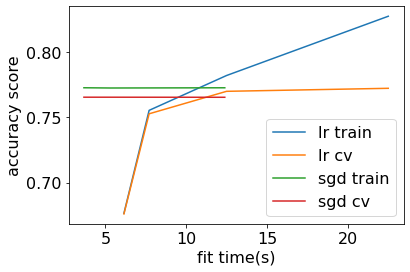

In [28]:
plt.plot(results_lr["mean_fit_time"], results_lr["mean_train_score"], label="lr train")
plt.plot(results_lr["mean_fit_time"], results_lr["mean_test_score"], label="lr cv")
plt.plot(results_sgd["mean_fit_time"], results_sgd["mean_train_score"], label="sgd train")
plt.plot(results_sgd["mean_fit_time"], results_sgd["mean_test_score"], label="sgd cv")
plt.xlabel("fit time(s)");
plt.ylabel("accuracy score");
plt.legend();

TL;DR if you don't want to wait that long, `SGDClassifier` will probably do better on a big dataset. 

In [29]:
# # TODO: Can use GridSearchCV to automate this?

# n_iter_lr = [10, 30, 100, 300, 1000, 3000]
# fit_times_lr = []
# train_scores_lr = []
# test_scores_lr = []
# for n_iter in n_iter_lr:
#     lr = LogisticRegression(max_iter=n_iter)
#     time = %timeit -o -n1 -r1 lr.fit(X_train, y_train)
#     fit_times_lr.append(time)
#     train_scores_lr.append(lr.score(X_train, y_train))
#     test_scores_lr.append(lr.score(X_test, y_test))
    
# n_iter_sgd = [100, 300, 1000, 3000, 10000, 30000]
# fit_times_sgd = []
# train_scores_sgd = []
# test_scores_sgd = []
# for n_iter in n_iter_sgd:
#     lr = SGDClassifier(loss="log", max_iter=n_iter)
#     lr.fit(X_train, y_train)
#     train_scores_lr.append(lr.score(X_train, y_train))
#     test_scores_lr.append(lr.score(X_test, y_test))